# 5. Model Benchmarking - Titanic Survival

**Goal:** Compare multiple machine learning algorithms to establish a performance baseline for predicting survival.

**Algorithms Evaluated:**
1. **Logistic Regression** (Baseline linear model)
2. **Support Vector Machine (SVM)** (Distance-based)
3. **K-Nearest Neighbors (KNN)** (Distance-based)
4. **Random Forest** (Ensemble bagging)
5. **XGBoost** (Ensemble boosting)

**Metric:** Accuracy (primary), ROC-AUC (secondary)
**Validation:** 5-Fold Stratified Cross-Validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set_style("whitegrid")
np.random.seed(42)

## 1. Data Preparation

We build a robust preprocessing pipeline to handle missing values and encoding within the cross-validation loop to prevent data leakage.

In [2]:
# Load Raw Data
df = pd.read_csv('../data/raw/train.csv')

# Basic Feature Engineering
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Select Features and Target
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']]
y = df['Survived']

# Define Preprocessing Steps
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 2. Multi-Model Benchmark

We evaluate all algorithms using standard 5-fold CV.

In [3]:
models = [
    ('LogReg', LogisticRegression(max_iter=1000, random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

results = []
names = []

print("Model Performance (Accuracy):")
print("-"*30)

for name, model in models:
    # Create full pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    cv_results = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} (+/- {cv_results.std():.4f})")

Model Performance (Accuracy):
------------------------------
LogReg: 0.8204 (+/- 0.0167)


SVM: 0.8350 (+/- 0.0233)
KNN: 0.8171 (+/- 0.0440)


RandomForest: 0.7969 (+/- 0.0302)


C:\Users\Ravikiran Bhonagiri\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [18:09:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ravikiran Bhonagiri\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [18:09:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ravikiran Bhonagiri\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [18:09:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: 0.8092 (+/- 0.0233)


C:\Users\Ravikiran Bhonagiri\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [18:09:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ravikiran Bhonagiri\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [18:09:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 3. Results Visualization

Boxplot comparison of cross-validation variance.

C:\Users\Ravikiran Bhonagiri\AppData\Local\Temp\ipykernel_24704\2983784165.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, patch_artist=True)


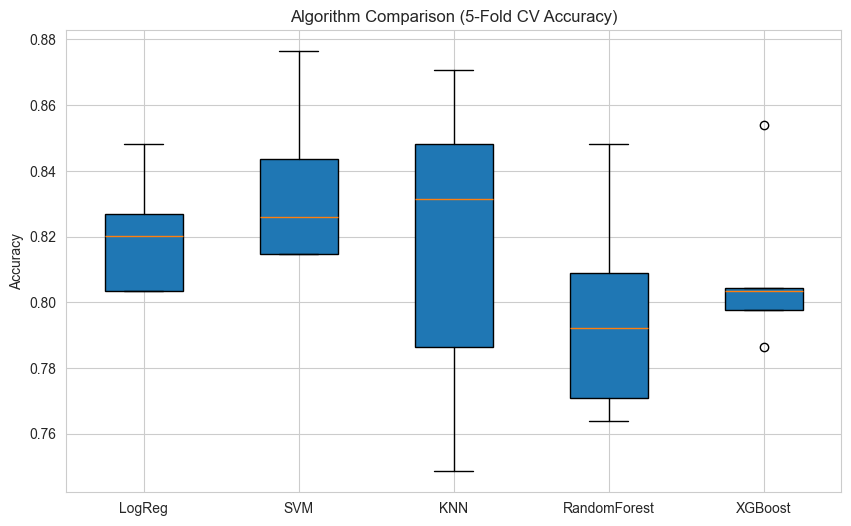

In [4]:
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names, patch_artist=True)
plt.title('Algorithm Comparison (5-Fold CV Accuracy)')
plt.ylabel('Accuracy')
plt.show()